In [1]:

import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
from lsst.ip.diffim import GetCoaddAsTemplateTask, GetCalexpAsTemplateTask

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [27]:
gtTask = GetCalexpAsTemplateTask()
visits = [850586 , 849373, 849686, 850180, 850586, 851060]

DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

dataId = {'visit': visits[0] , 'filter':'r' , 'ccd':14}

diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)
sciExp  = butler.get("calexp", dataId)

dr = butler.dataRef("calexp", dataId=dataId)
results = gtTask.run( sciExp, dr, templateIdList=[{'visit':986881, 'ccd':14}])

.....
{'ccd': 14, 'visit': 986881}
.....


In [45]:
import lsst.pex.config as pexConfig
from lsst.ip.diffim.psfMatch import PsfMatchTask, PsfMatchConfigDF, PsfMatchConfigAL
from lsst.meas.algorithms import SourceDetectionTask, getBackground
from lsst.meas.base import SingleFrameMeasurementTask


class ImagePsfMatchConfig(pexConfig.Config):
    """!Configuration for image-to-image Psf matching"""
    kernel = pexConfig.ConfigChoiceField(
        doc="kernel type",
        typemap=dict(
            AL=PsfMatchConfigAL,
            DF=PsfMatchConfigDF
        ),
        default="AL",
    )
    selectDetection = pexConfig.ConfigurableField(
        target=SourceDetectionTask,
        doc="Initial detections used to feed stars to kernel fitting",
    )
    selectMeasurement = pexConfig.ConfigurableField(
        target=SingleFrameMeasurementTask,
        doc="Initial measurements used to feed stars to kernel fitting",
    )

    def setDefaults(self):
        # High sigma detections only
        self.selectDetection.reEstimateBackground = False
        self.selectDetection.thresholdValue = 10.0

        # Minimal set of measurments for star selection
        self.selectMeasurement.doApplyApCorr = "no"
        self.selectMeasurement.algorithms.names.clear()
        self.selectMeasurement.algorithms.names = ('base_SdssCentroid', 'base_PsfFlux', 'base_PixelFlags',
                                                   'base_SdssShape', 'base_GaussianFlux', 'base_SkyCoord')
        self.selectMeasurement.slots.modelFlux = None
        self.selectMeasurement.slots.apFlux = None
        self.selectMeasurement.slots.calibFlux = None

In [48]:
import lsst.afw.math as afwMath


config = ImagePsfMatchConfig()
kConfig = config.kernel.active
warper = afwMath.Warper.fromConfig(kConfig.warpingConfig)
templateExposure = warper.warpExposure(sciExp.getWcs(), results.exposure, destBBox=sciExp.getBBox())

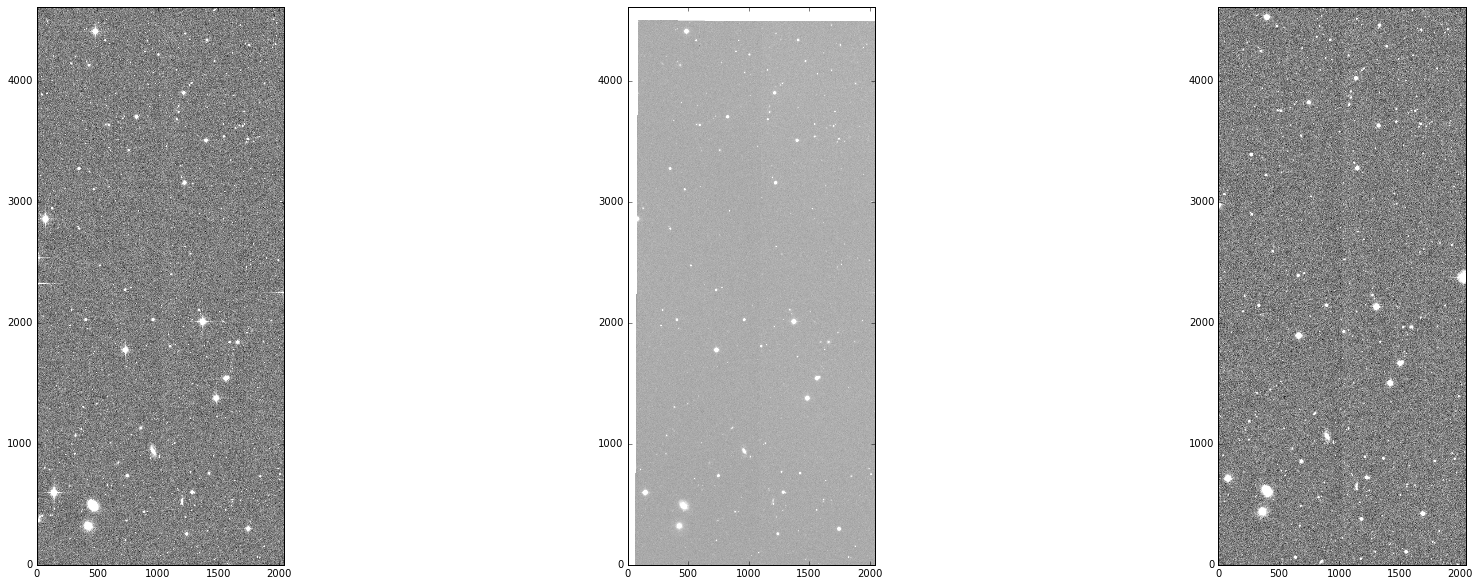

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(30,10))
fig.add_subplot(1, 3, 1) 

im_arr = sciExp.getMaskedImage().getImage().getArray()
plt.imshow(im_arr, cmap = 'gray', origin='lower', vmin=-100, vmax=100)

fig.add_subplot(1, 3, 2) 

tmp_arr = templateExposure.getMaskedImage().getImage().getArray()
plt.imshow(tmp_arr, cmap = 'gray', origin='lower', vmin=500, vmax=1500)


fig.add_subplot(1, 3, 3) 
tmpExp  = butler.get("calexp", {'visit':986881, 'ccd':14, 'filter':'r'})
to_arr = tmpExp.getMaskedImage().getImage().getArray()
plt.imshow(to_arr, cmap = 'gray', origin='lower', vmin=-100, vmax=100)

(-500, 500)

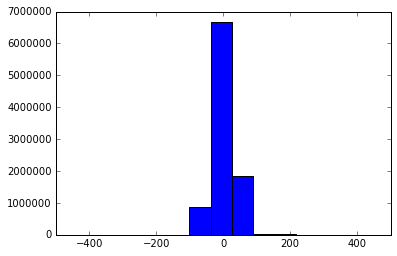

In [39]:

image_hist = plt.hist(list(to_arr.flat), 1000)
plt.xlim(xmin=-500, xmax=500)